In [1]:
#Data downloaded from this link: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
#please make sure to download all the relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt


path = "/Users/natesh/Documents/cs1009a/nyctaxidata/yellow_tripdata_2024-01.parquet"
# Load the parquet file into a pandas DataFrame
nyc_taxi_data = pd.read_parquet(path)

# Display the first few rows of the dataset to understand its structure
nyc_taxi_data.head()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/natesh/Documents/cs1009a/nyctaxidata/yellow_tripdata_2024-01.parquet'

In [2]:
nyc_taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [3]:
# Display summary statistics for trip distances
trip_distance_summary = nyc_taxi_data['trip_distance'].describe()
print(trip_distance_summary)
#Hmm, what do you see below?

count    2.964624e+06
mean     3.652169e+00
std      2.254626e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.680000e+00
75%      3.110000e+00
max      3.127223e+05
Name: trip_distance, dtype: float64


In [4]:
# Define a reasonable threshold for trip distances; I chose 50,
# 30 is just as fine.

threshold = 50

# Filter out the outliers (trips greater than the threshold)
filtered_data = nyc_taxi_data[nyc_taxi_data['trip_distance'] <= threshold]
filtered_summary = filtered_data['trip_distance'].describe()
print(filtered_summary)

count    2.964212e+06
mean     3.219377e+00
std      4.316519e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.680000e+00
75%      3.110000e+00
max      4.998000e+01
Name: trip_distance, dtype: float64


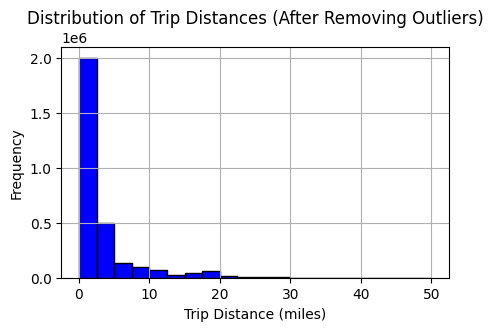

In [5]:
# Plot the distribution of trip distances after removing outliers
plt.figure(figsize=(5, 3))
plt.hist(filtered_data['trip_distance'], bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Trip Distances (After Removing Outliers)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



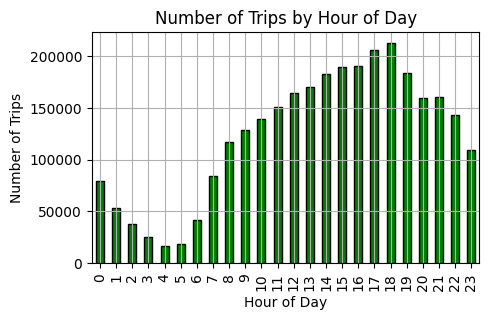

In [6]:
# Filter the dataset to remove outliers (trip distances > 50 miles)
threshold = 50
filtered_data = nyc_taxi_data[nyc_taxi_data['trip_distance'] <= threshold]



# Ensure you are working with the filtered data (removing trip distances > 50 miles)
filtered_data = nyc_taxi_data[nyc_taxi_data['trip_distance'] <= 50].copy()

# Extract the hour from the pickup datetime
filtered_data.loc[:, 'pickup_hour'] = filtered_data['tpep_pickup_datetime'].dt.hour

# Group by the hour of day and count trips
trips_by_hour_filtered = filtered_data.groupby('pickup_hour').size()

# Plot the number of trips by hour for the filtered data
plt.figure(figsize=(5, 3))
trips_by_hour_filtered.plot(kind='bar', color='green', edgecolor='black')
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()


In [7]:
# Load the taxi zone centroids CSV file
taxi_zones = pd.read_csv('taxi_zones.csv')

# Display the first few rows to check the structure
print(taxi_zones.head())


   OBJECTID  Shape_Leng                                           the_geom  \
0         1    0.116357  MULTIPOLYGON (((-74.18445299999996 40.69499599...   
1         2    0.433470  MULTIPOLYGON (((-73.82337597260663 40.63898704...   
2         3    0.084341  MULTIPOLYGON (((-73.84792614099985 40.87134223...   
3         4    0.043567  MULTIPOLYGON (((-73.97177410965318 40.72582128...   
4         5    0.092146  MULTIPOLYGON (((-74.17421738099989 40.56256808...   

   Shape_Area                     zone  LocationID        borough  
0    0.000782           Newark Airport           1            EWR  
1    0.004866              Jamaica Bay           2         Queens  
2    0.000314  Allerton/Pelham Gardens           3          Bronx  
3    0.000112            Alphabet City           4      Manhattan  
4    0.000498            Arden Heights           5  Staten Island  


In [8]:
import geopandas as gpd
from shapely import wkt

# Convert the geometry from WKT (well-known text) format to actual geometric objects
taxi_zones = taxi_zones.dropna(subset=['the_geom'])  # Drop rows with missing geometry
taxi_zones['geometry'] = taxi_zones['the_geom'].apply(wkt.loads)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(taxi_zones, geometry='geometry')

# Calculate centroids for each zone
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroid
gdf['Latitude'] = gdf['centroid'].apply(lambda point: point.y)
gdf['Longitude'] = gdf['centroid'].apply(lambda point: point.x)

# Check the GeoDataFrame with the centroids
print(gdf[['LocationID', 'Latitude', 'Longitude']].head())


   LocationID   Latitude  Longitude
0           1  40.691831 -74.174000
1           2  40.616745 -73.831299
2           3  40.864474 -73.847422
3           4  40.723752 -73.976968
4           5  40.552659 -74.188484


In [9]:
# Merge filtered data with the taxi zones data for pickup locations
filtered_data = filtered_data.merge(taxi_zones, how='left', left_on='PULocationID', right_on='LocationID')

# Check the new DataFrame to make sure the merge worked
print(filtered_data.head())


   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.80         1.0                  N           211           148   

   payment_type  ...  Airport_fee  pickup_hour  OBJECTID  Shape_Leng  \
0 

In [10]:
# Merge the centroid data with the filtered taxi data for pickup locations
filtered_data = filtered_data.merge(gdf[['LocationID', 'Latitude', 'Longitude']], how='left', left_on='PULocationID', right_on='LocationID')

# Check if the merge worked
print(filtered_data[['PULocationID', 'Latitude', 'Longitude']].head())


   PULocationID   Latitude  Longitude
0           186  40.748497 -73.992438
1           140  40.765484 -73.954739
2           236  40.780436 -73.957012
3            79  40.727620 -73.985937
4           211  40.723888 -74.001538


In [11]:
import folium
from folium.plugins import HeatMap

# Create a base map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Extract the pickup coordinates for the heatmap
pickup_coords = filtered_data[['Latitude', 'Longitude']].dropna()

# Add the heatmap to the map
HeatMap(pickup_coords.values, radius=8, max_zoom=13).add_to(nyc_map)

# Save the heatmap as an HTML file to view it
nyc_map.save("nyc_pickup_heatmap.html")


In [12]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Randomly sample 100,000 rows to reduce the size (if your system can handle it)
sampled_data = filtered_data[['Latitude', 'Longitude']].dropna().sample(100000)

# Create a base map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add the heatmap to the map
HeatMap(sampled_data.values, radius=8, max_zoom=13).add_to(nyc_map)

# Display the map inline in the notebook
nyc_map


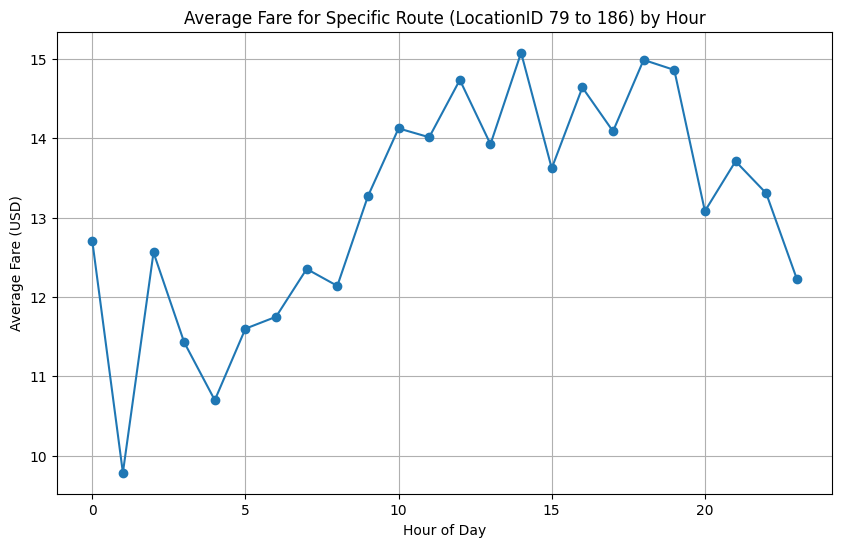

In [13]:
# Load and filter data
path = "/Users/natesh/Documents/cs1009a/nyctaxidata/yellow_tripdata_2024-01.parquet"
nyc_taxi_data = pd.read_parquet(path)

# Filter trips to remove outliers (trip distances > 50 miles)
threshold = 50
filtered_data = nyc_taxi_data[nyc_taxi_data['trip_distance'] <= threshold].copy()

# Ensure 'tpep_pickup_datetime' is in datetime format
filtered_data['tpep_pickup_datetime'] = pd.to_datetime(filtered_data['tpep_pickup_datetime'])

# Step 1: Filter trips within a specific distance range (e.g., 1.5 to 2.0 miles)
distance_range = (1.5, 2.0)
filtered_same_distance = filtered_data[(filtered_data['trip_distance'] >= distance_range[0]) & 
                                       (filtered_data['trip_distance'] <= distance_range[1])].copy()

# Step 2: Group by location pairs (PULocationID and DOLocationID)
# Use .loc[] to avoid the warning
filtered_same_distance.loc[:, 'pickup_hour'] = filtered_same_distance['tpep_pickup_datetime'].dt.hour

# Group by location pair (PULocationID, DOLocationID) and hour
grouped = filtered_same_distance.groupby(['PULocationID', 'DOLocationID', 'pickup_hour'])['fare_amount'].mean().reset_index()

# Step 3: Plot the fare changes for a specific location pair over time
# Example: Pick a specific location pair (you can change the IDs to fit a common route)
specific_route = grouped[(grouped['PULocationID'] == 79) & (grouped['DOLocationID'] == 186)]

# Plot the fare amount over the hours of the day for this specific route
plt.figure(figsize=(10, 6))
plt.plot(specific_route['pickup_hour'], specific_route['fare_amount'], marker='o', linestyle='-')
plt.title('Average Fare for Specific Route (LocationID 79 to 186) by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare (USD)')
plt.grid(True)
plt.show()



<IPython.core.display.Javascript object>


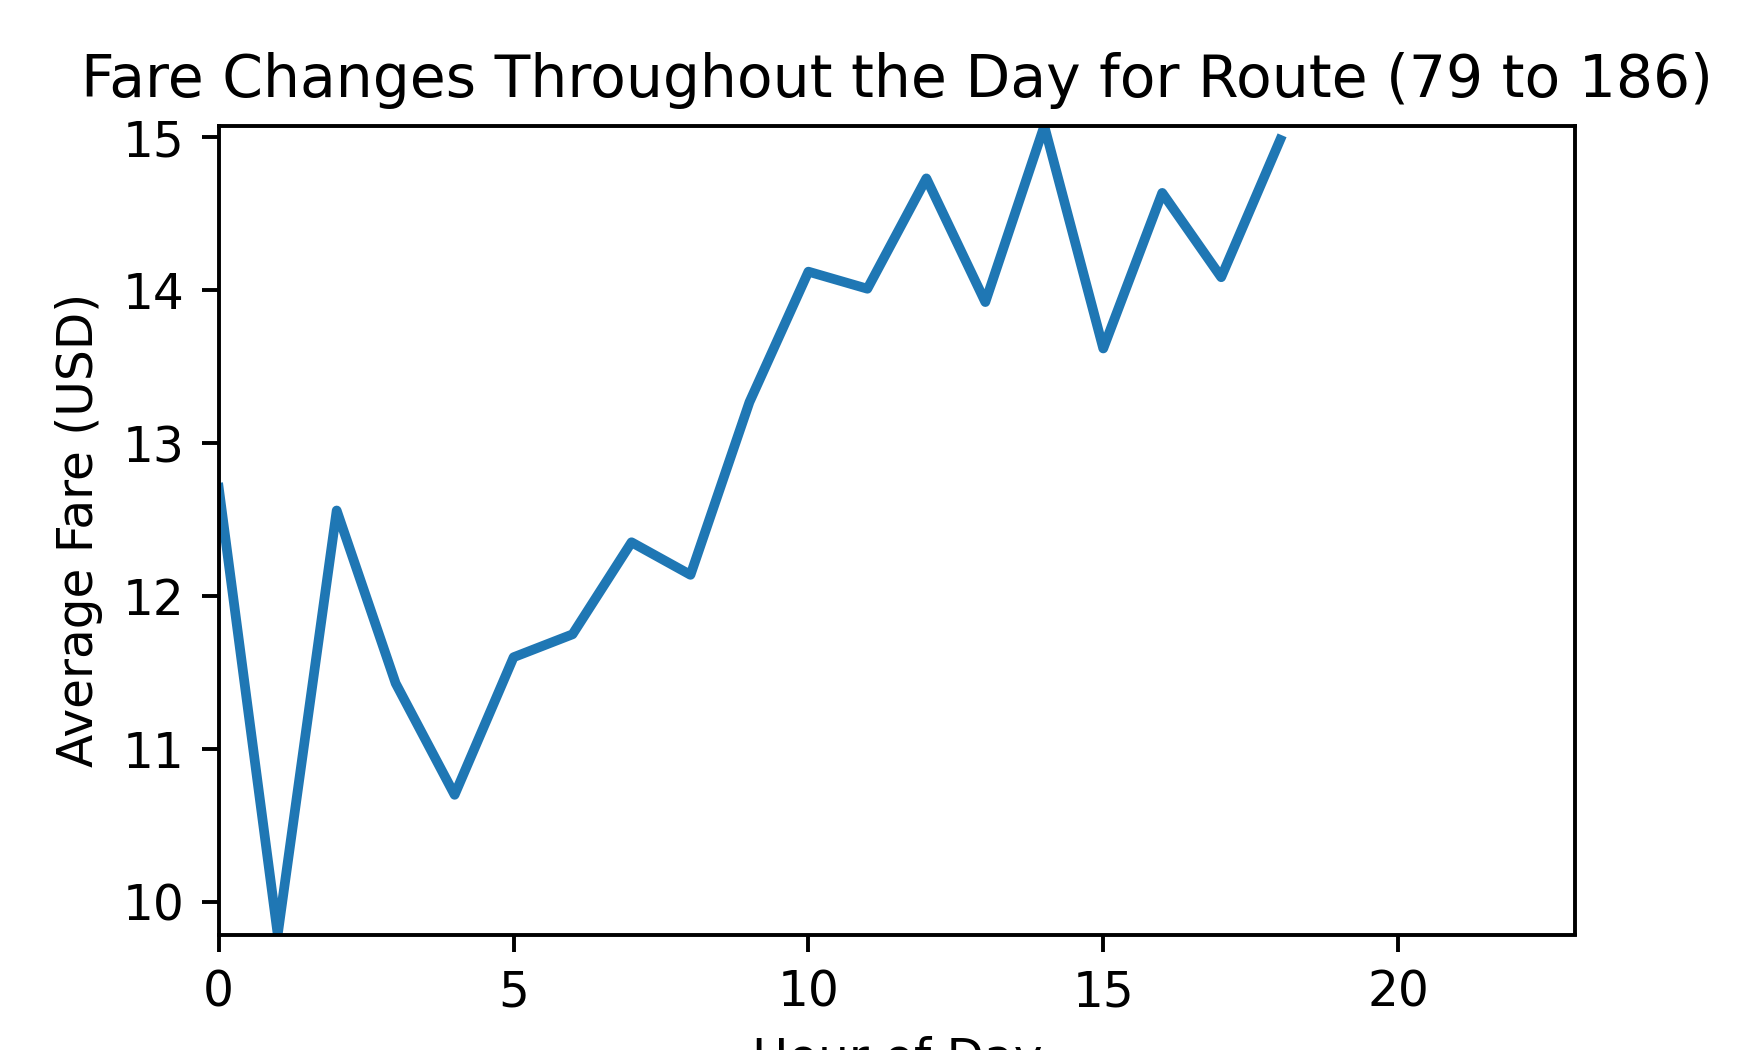

In [14]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

# Load and filter data
path = "/Users/natesh/Documents/cs1009a/nyctaxidata/yellow_tripdata_2024-01.parquet"
nyc_taxi_data = pd.read_parquet(path)

# Filter trips to remove outliers (trip distances > 50 miles)
threshold = 50
filtered_data = nyc_taxi_data[nyc_taxi_data['trip_distance'] <= threshold].copy()

# Ensure 'tpep_pickup_datetime' is in datetime format
filtered_data['tpep_pickup_datetime'] = pd.to_datetime(filtered_data['tpep_pickup_datetime'])

# Step 1: Filter trips within a specific distance range (e.g., 1.5 to 2.0 miles)
distance_range = (1.5, 2.0)
filtered_same_distance = filtered_data[(filtered_data['trip_distance'] >= distance_range[0]) & 
                                       (filtered_data['trip_distance'] <= distance_range[1])].copy()

# Extract the hour of the pickup
filtered_same_distance.loc[:, 'pickup_hour'] = filtered_same_distance['tpep_pickup_datetime'].dt.hour

# Group by location pair (PULocationID and DOLocationID) and hour
grouped = filtered_same_distance.groupby(['PULocationID', 'DOLocationID', 'pickup_hour'])['fare_amount'].mean().reset_index()

# Pick a specific route to animate (replace with your desired LocationIDs)
specific_route = grouped[(grouped['PULocationID'] == 79) & (grouped['DOLocationID'] == 186)]

# Step 2: Set up the plot for animation
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_xlim(0, 23)  # Hours of the day
ax.set_ylim(specific_route['fare_amount'].min(), specific_route['fare_amount'].max())  # Fare range
line, = ax.plot([], [], lw=2)
ax.set_title('Fare Changes Throughout the Day for Route (79 to 186)')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Fare (USD)')

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Animation function
def animate(i):
    x = specific_route['pickup_hour'][:i+1]
    y = specific_route['fare_amount'][:i+1]
    line.set_data(x, y)
    return line,

# Create the animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(specific_route), interval=200, blit=True)

# Show the animation
plt.show()
